# Example with Both Configuration and Motion Contraints

A four bar linkage made up of points $P_1,P_2,P_3,P_4$ such that $P_1$ and $P_4$ are both fixed on a stationary line at a distance $l_4$ apart. $P_2$ and $P_3$ are also particles with masses $m_2$ and $m_3$. $P_2$ is distance $l_1$ from $P_1$, $P_3$ is distance $l_2$ from $P_2$, and $P_4$ is distance $l_3$ from $P_3$. Additionally, there is a third particle $P_5$ located $l_5$ from $P_3$. $P_5$ has a motion constraint that only allows motion along the line connecting $P_3$ and $P_5$. This problem has a configuration constraint that enforces the four bar linkage configuration and a motion constraint.

In [1]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting()

# Define variables

Introduce the four non-minimal generalized coordinates, four generalized speeds, and a specified torque to drive one link.

In [2]:
q1, q2, q3, q4 = me.dynamicsymbols('q1:5')
u1, u2, u3, u4 = me.dynamicsymbols('u1:5')
T = me.dynamicsymbols('T')

Introduce all of the necessary constants

In [3]:
l1, l2, l3, l4, l5 = sm.symbols('l1:6')
m2, m3, m5, g = sm.symbols('m2, m3, m5, g')

# Reference Frame Orientations

A reference frame is attached to each link:

- $N$ for $P_1$ to $P_4$
- $A$ for $P_1$ to $P_2$
- $B$ for $P_2$ to $P_3$
- $C$ for $P_3$ to $P_4$
- $D$ for $P_3$ to $P_5$

In [4]:
N = me.ReferenceFrame('N')
A = N.orientnew('A', 'Axis', (q1, N.z))
B = A.orientnew('B', 'Axis', (q2, -A.z))
C = B.orientnew('C', 'Axis', (q3, -B.z))
D = B.orientnew('D', 'Axis', (q4, -B.z))

# Point Locations

In [5]:
P1 = me.Point('P1')
P2 = P1.locatenew('P2', l1*A.x)
P3 = P2.locatenew('P3', l2*B.x)
P4 = P3.locatenew('P4', l3*C.x)
P5 = P3.locatenew('P5', l5*D.x)

# Configuration Constraints

This is the vector equation that will be used to create the configuration constraints. Two of the five generalized coordinates are dependent due to the two equations that arise from this vector equation.

In [6]:
loop = P4.pos_from(P1) - l4*N.x
loop

There are two configuration constraints and thus only one of the configuration variables is necessary for speciying the complete coniguration of the system. In this case it may be possible to solve these two nonlinear equations for $q_2$ and $q_3$, but that is often not the case.

In [7]:
config_con1 = loop.dot(N.x).simplify()
config_con1

In [8]:
config_con2 = loop.dot(N.y).simplify()
config_con2

# Kinematical Differential Equations

Introduce a generalized speed for each generalized coordinate (for both independent and dependent generalized coordinates).

In [9]:
qdots = {q.diff(): u for q, u in zip((q1, q2, q3, q4), (u1, u2, u3 ,u4))}
qdots

# Set Velocities in Terms of the Generalized Speeds

In [10]:
A.set_ang_vel(N, u1*N.z)
B.set_ang_vel(A, -u2*A.z)
C.set_ang_vel(B, -u3*B.z)
D.set_ang_vel(B, -u4*B.z)

In [11]:
P1.set_vel(N, 0)
P1.vel(N)

In [12]:
P2.v2pt_theory(P1, N, A)

In [13]:
P3.v2pt_theory(P2, N, B)

In [14]:
P5.v2pt_theory(P3, N, D)

# Motion Constraints

$P_5$ can only have motion along the line from $P_3$ to $P_5$, so create this constraint. This is the single true non-holonomic constraint.

In [15]:
mot_con = P5.vel(N).dot(D.y).simplify()
mot_con

Also introduce two motion constraints associated with the two holonomic configuration constraints. The configuration constraints can be differentitated with respect to time to obtain them.

In [16]:
t = me.dynamicsymbols._t

In [17]:
config_con1_dot = config_con1.diff(t).subs(qdots)
config_con1_dot

In [18]:
config_con2_dot = config_con2.diff(t).subs(qdots)
config_con2_dot

Note that these are equivalent to setting the velocity of $P_4$ to zero.

In [19]:
P4.v2pt_theory(P3, N, C).dot(N.x).simplify()

In [20]:
P4.v2pt_theory(P3, N, C).dot(N.y).simplify()

# Accelerations

Make sure all of the accelerations relevant to forming Kane's equations do not have any $\dot{q}$'s.

In [21]:
A.ang_acc_in(N)

In [22]:
P2.acc(N)

In [23]:
P3.acc(N)

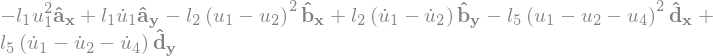

In [24]:
P5.acc(N)

# Bodies

Create the three particles.

In [25]:
particle2 = me.Particle('P2', P2, m2)
particle3 = me.Particle('P3', P3, m3)
particle5 = me.Particle('P5', P5, m5)

In [26]:
particles = [particle2, particle3, particle5]

# Loads

The three particles have gravity acting on them and the specified torque is applied between A and N.

In [27]:
loads = [(P2, -m2*g*N.y),
         (P3, -m3*g*N.y),
         (P5, -m5*g*N.y),
         (A, T*N.z)]

# Equations of Motion

In [28]:
kane = me.KanesMethod(N, # inertial reference frame
                      (q1, q4), # only two independent generalized coordinates
                      (u1,), # only one independent generalized speed
                      kd_eqs=[qd - u for qd, u in qdots.items()], # q' = u for all coordinates
                      q_dependent=(q2, q3), # two depdendent coordinates from the kinematic loop
                      configuration_constraints=[config_con1,  # two kinematic loop config constraints
                                                 config_con2],
                      u_dependent=(u2, u3, u4), # dependent generalized speeds
                      velocity_constraints=[mot_con,  # nonholonomic constraint
                                            config_con1_dot,  # two holonomic motion constraints
                                            config_con2_dot],
                      # acc constraints are required to ensure all qdots are properly substituted (will not be required in SymPy 1.6)
                      acceleration_constraints=[mot_con.diff(t).subs(qdots),
                                                config_con1_dot.diff(t).subs(qdots),
                                                config_con2_dot.diff(t).subs(qdots)])

In [29]:
fr, frstar = kane.kanes_equations(particles, loads=loads)

In [30]:
zero = fr + frstar
zero.shape

In [31]:
me.find_dynamicsymbols(zero)

Note the order of the generalized coordinates and speeds.

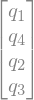

In [32]:
kane.q

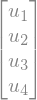

In [33]:
kane.u

In [34]:
kane.kindiffdict()

All $\dot{q}$'s have been eliminated from the equations of motion.

In [35]:
me.find_dynamicsymbols(kane.mass_matrix_full)

In [36]:
me.find_dynamicsymbols(kane.forcing_full)

# Integrate the Equations of Motion

In [37]:
import numpy as np
from scipy.optimize import fsolve
from pydy.system import System

In [38]:
sys = System(kane)

In [39]:
l1_val = 0.8
l2_val = 2.0
l3_val = 1.0
l4_val = 2.0
l5_val = 3.0

sys.constants = {g: 9.81,
                 l1: l1_val,
                 l2: l2_val,
                 l3: l3_val,
                 l5: l5_val,
                 m2: 1.0,
                 m3: 1.0,
                 m5: 1.0}

## Initial Conditions

These must satisfy the configuration constraints so use `fsolve` to find a satifactory numerical solution.

Choose a value for the independent generalized coordinate:

In [40]:
q1_0 = np.deg2rad(10.0)

Create a function that evaluates the constraints and find compatible values for the two dependent generalized coordinates.

In [41]:
eval_config_con = sm.lambdify((q1, q2, q3, l1, l2, l3, l4),
                              sm.Matrix([config_con1, config_con2]))

In [42]:
eval_config_con_fsolve = lambda x, q1, l1, l2, l3, l4: np.squeeze(eval_config_con(q1, x[0], x[1], l1, l2, l3, l4))

In [43]:
q2_0, q3_0 = fsolve(eval_config_con_fsolve, np.ones(2), args=(q1_0, l1_val, l2_val, l3_val, l4_val))

np.rad2deg(q1_0), np.rad2deg(q2_0), np.rad2deg(q3_0)

In [44]:
sys.initial_conditions = {q1: q1_0,
                          q2: q2_0,
                          q3: q3_0,
                          q4: np.deg2rad(-90.0),
                          u1: 0.0,
                          u2: 0.0,
                          u3: 0.0,
                          u4: 0.0}

## Set Output Times

In [45]:
duration = 4.0
fps = 60.0
sys.times = np.linspace(0.0, duration, num=int(fps*duration))

## Specified Torque

Create a function that turns the torque on for a short duration and then off. This will get the linkage moving.

In [46]:
def step_pulse(x, t):
    if t < 2.0:
        T = 15.0
    else:
        T = 0.0
    return np.array([T])

In [47]:
sys.specifieds = {T: step_pulse}

## Integrate

In [48]:
x = sys.integrate()

# Plot the State Trajectories

In [49]:
import matplotlib.pyplot as plt

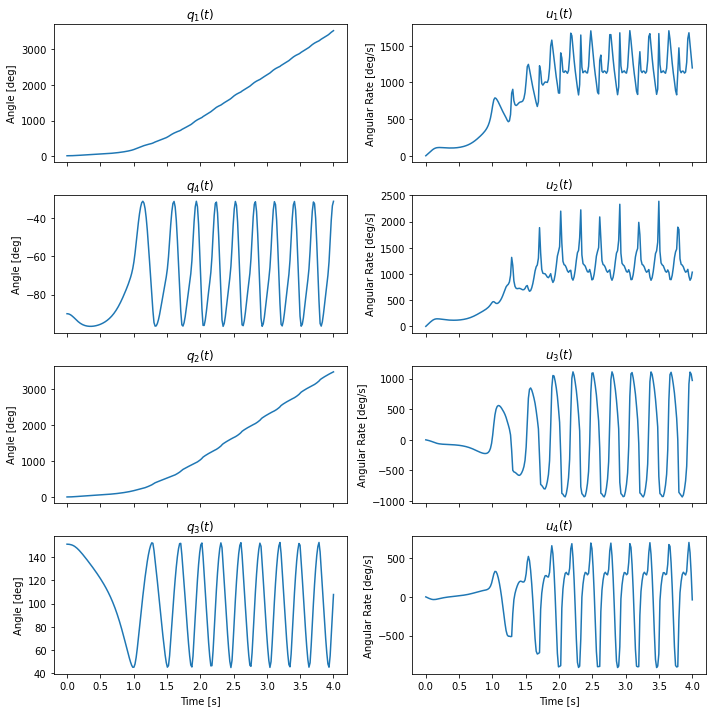

In [50]:
fig, axes = plt.subplots(4, 2, sharex=True)
fig.set_size_inches(10, 10)

for i, (xi, ax, s) in enumerate(zip(x.T, axes.T.flatten(), sys.states)):
    ax.plot(sys.times, np.rad2deg(xi))
    title = sm.latex(s, mode='inline')
    ax.set_title(title)
    if 'q' in title:
        ax.set_ylabel('Angle [deg]')
    else:
        ax.set_ylabel('Angular Rate [deg/s]')

axes[3, 0].set_xlabel('Time [s]')
axes[3, 1].set_xlabel('Time [s]')

plt.tight_layout()

# Inspect the configuration and motion constraints

The two holonomic configuration constraints should evaluate to zero for each time step, but since we did not explicitly enforce the constraint during integration error can accumulate.

Text(0, 0.5, 'Configuration Constraint Value [m]')

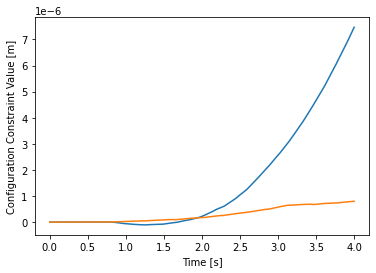

In [51]:
config_constraint_vals = eval_config_con(x[:, 0],  # q1
                                         x[:, 2],  # q2
                                         x[:, 3],  # q3,
                                         l1_val, l2_val, l3_val, l4_val).squeeze()

fig, ax = plt.subplots()
ax.plot(sys.times, config_constraint_vals.T)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Configuration Constraint Value [m]')

In [52]:
eval_motion_con = sm.lambdify((q1, q2, q3, q4, u1, u2, u3, u4, l1, l2, l3, l4, l5),
                              sm.Matrix([mot_con, config_con1_dot, config_con2_dot]))

In [53]:
motion_constraint_vals = eval_motion_con(x[:, 0],  # q1
                                         x[:, 2],  # q2
                                         x[:, 3],  # q3
                                         x[:, 1],  # q4
                                         x[:, 4],  # u1
                                         x[:, 5],  # u2
                                         x[:, 6],  # u3
                                         x[:, 7],  # u4
                                         l1_val, l2_val, l3_val, l4_val, l5_val).squeeze()

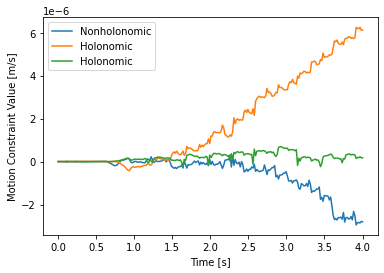

In [54]:
fig, ax = plt.subplots()
ax.plot(sys.times, motion_constraint_vals.T)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Motion Constraint Value [m/s]')
ax.legend(['Nonholonomic', 'Holonomic', 'Holonomic'])

These constraints grow with time and can exceed a desirable bound, so be aware!

# Animate the linkage

In [55]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

The location of the moving points will be needed:

In [56]:
P2.pos_from(P1).express(N).simplify()

In [57]:
P3.pos_from(P2).express(N).simplify()

In [58]:
P5.pos_from(P3).express(N).simplify()

Note that the coordinates are not in a necessarily expected order:

In [59]:
q1_vals = x[:, 0]
q2_vals = x[:, 2]
q3_vals = x[:, 3]
q4_vals = x[:, 1]

p2_xy = np.array([l1_val*np.cos(q1_vals),
                  l1_val*np.sin(q1_vals)])

p3_xy = p2_xy + np.array([l2_val*np.cos(q1_vals - q2_vals),
                          l2_val*np.sin(q1_vals - q2_vals)])

p5_xy = p3_xy + np.array([l5_val*np.cos(-q1_vals + q2_vals + q4_vals),
                          -l5_val*np.sin(-q1_vals + q2_vals + q4_vals)])

Create a base plot with the initial state values.

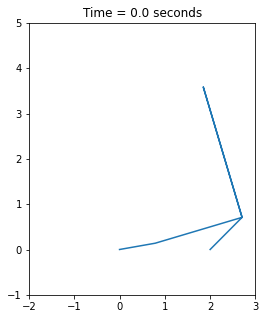

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 5))
line, = ax.plot([0.0, p2_xy[0, 0], p3_xy[0, 0], p5_xy[0, 0], p3_xy[0, 0], l4_val],
                [0.0, p2_xy[1, 0], p3_xy[1, 0], p5_xy[1, 0], p3_xy[1, 0], 0.0])
title = 'Time = {:0.1f} seconds'
ax.set_title(title.format(0.0))
ax.set_ylim((-1.0, 5.0))
ax.set_xlim((-2.0, 3.0))
ax.set_aspect('equal')

In [61]:
def update(i):
    xdata = [0.0, p2_xy[0, i], p3_xy[0, i], p5_xy[0, i], p3_xy[0, i], l4_val]
    ydata = [0.0, p2_xy[1, i], p3_xy[1, i], p5_xy[1, i], p3_xy[1, i], 0.0]
    line.set_data(xdata, ydata)
    ax.set_title(title.format(sys.times[i]))
    return line,

ani = FuncAnimation(fig, update, save_count=len(sys.times))

In [62]:
HTML(ani.to_jshtml(fps=fps))